<a href="https://colab.research.google.com/github/sohomgit/time_series_fe/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [2]:
# imports
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/FE_Time_Series")

In [4]:
path = os.path.join(os.getcwd(),'Datasets','online_retail_dataset.csv')

In [5]:
# load weekly sales dataset

# Adjust the following function based on where
# you stored the dataset
filename = "../../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    path,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

# df.columns = ['sales']

# df.head()

## Plot time series

In [6]:
df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


<Axes: xlabel='week'>

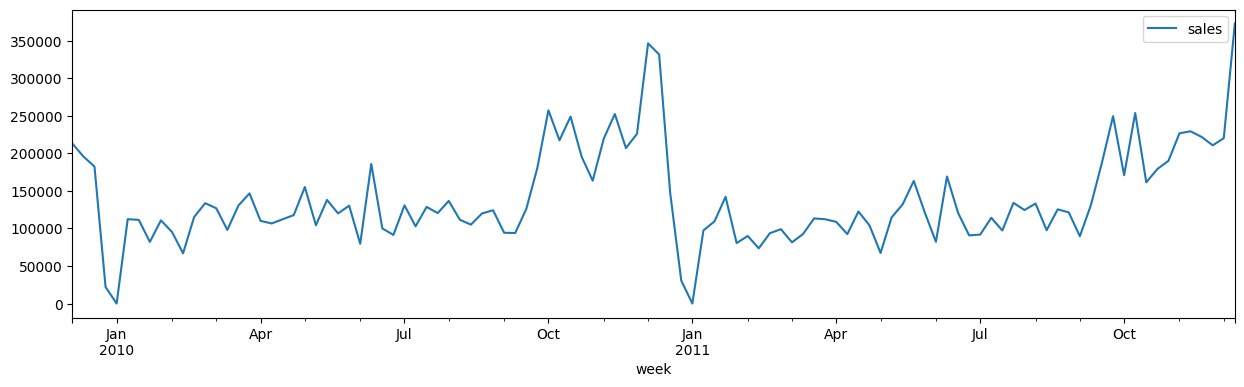

In [7]:
df.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [8]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.1 MB/s eta 0:00:00


In [9]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import LagFeatures,WindowFeatures
from sklearn.pipeline import Pipeline

In [10]:
# Create the feature month from the timestamp.
dtf = DatetimeFeatures(
    #the date time variabble
    variables="index",
    features_to_extract=["month"],

)

In [11]:
df = dtf.fit_transform(df)
df.head()

,sales,month
week,,
2009-12-06,213000.35,12
2009-12-13,195810.04,12
2009-12-20,182396.74,12
2009-12-27,22007.77,12
2010-01-03,0.00,1


In [12]:
# Transform the month with the sine and cosine functions
cyclicf= CyclicalFeatures(
    variables=["month"],
    drop_original=False
)
df = cyclicf.fit_transform(df)
df.head()

,sales,month,month_sin,month_cos
week,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000
2009-12-13,195810.04,12,-2.449294e-16,1.000000
2009-12-20,182396.74,12,-2.449294e-16,1.000000
2009-12-27,22007.77,12,-2.449294e-16,1.000000
2010-01-03,0.00,1,5.000000e-01,0.866025


In [13]:
# Create the feature lag-1 by lagging 1 week of data.
lagf = LagFeatures(
    variables=["sales"],
    freq=['1W'],
    missing_values = "ignore",
)
df = lagf.fit_transform(df)
df.head()

,sales,month,month_sin,month_cos,sales_lag_1W
week,,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000,NaN
2009-12-13,195810.04,12,-2.449294e-16,1.000000,213000.35
2009-12-20,182396.74,12,-2.449294e-16,1.000000,195810.04
2009-12-27,22007.77,12,-2.449294e-16,1.000000,182396.74
2010-01-03,0.00,1,5.000000e-01,0.866025,22007.77


In [14]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf = WindowFeatures(
    variables=["sales"],
    window=["14D","30D"],
    functions=["mean","max","min"],
    freq="1W",
    missing_values="ignore",
)


In [15]:
df = winf.fit_transform(df)

In [16]:
df.head(20)

,sales,month,month_sin,month_cos,sales_lag_1W,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min,sales_window_30D_mean,sales_window_30D_max,sales_window_30D_min
week,,,,,,,,,,,
2009-12-06,213000.350,12,-2.449294e-16,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.040,12,-2.449294e-16,1.000000e+00,213000.350,213000.3500,213000.350,213000.350,213000.350000,213000.350,213000.350
2009-12-20,182396.740,12,-2.449294e-16,1.000000e+00,195810.040,204405.1950,213000.350,195810.040,204405.195000,213000.350,195810.040
2009-12-27,22007.770,12,-2.449294e-16,1.000000e+00,182396.740,189103.3900,195810.040,182396.740,197069.043333,213000.350,182396.740
2010-01-03,0.000,1,5.000000e-01,8.660254e-01,22007.770,102202.2550,182396.740,22007.770,153303.725000,213000.350,22007.770
2010-01-10,112318.850,1,5.000000e-01,8.660254e-01,0.000,11003.8850,22007.770,0.000,122642.980000,213000.350,0.000
2010-01-17,111460.470,1,5.000000e-01,8.660254e-01,112318.850,56159.4250,112318.850,0.000,102506.680000,195810.040,0.000
2010-01-24,82065.331,1,5.000000e-01,8.660254e-01,111460.470,111889.6600,112318.850,111460.470,85636.766000,182396.740,0.000
2010-01-31,110790.591,1,5.000000e-01,8.660254e-01,82065.331,96762.9005,111460.470,82065.331,65570.484200,112318.850,0.000


In [17]:
df.isnull().sum()

sales                    0
month                    0
month_sin                0
month_cos                0
sales_lag_1W             1
sales_window_14D_mean    1
sales_window_14D_max     1
sales_window_14D_min     1
sales_window_30D_mean    1
sales_window_30D_max     1
sales_window_30D_min     1
dtype: int64

In [18]:
# Drop missing data.
print(df.shape)
imputer = DropMissingData()
df = imputer.fit_transform(df)
print(df.shape)

(106, 11)
(105, 11)


In [19]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop=["sales"])
df = drop_ts.fit_transform(df)
df.head()

,month,month_sin,month_cos,sales_lag_1W,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min,sales_window_30D_mean,sales_window_30D_max,sales_window_30D_min
week,,,,,,,,,,
2009-12-13,12,-2.449294e-16,1.000000,213000.35,213000.350,213000.35,213000.35,213000.350000,213000.35,213000.35
2009-12-20,12,-2.449294e-16,1.000000,195810.04,204405.195,213000.35,195810.04,204405.195000,213000.35,195810.04
2009-12-27,12,-2.449294e-16,1.000000,182396.74,189103.390,195810.04,182396.74,197069.043333,213000.35,182396.74
2010-01-03,1,5.000000e-01,0.866025,22007.77,102202.255,182396.74,22007.77,153303.725000,213000.35,22007.77
2010-01-10,1,5.000000e-01,0.866025,0.00,11003.885,22007.77,0.00,122642.980000,213000.35,0.00


## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [20]:
path = os.path.join(os.getcwd(),'Datasets','online_retail_dataset.csv')

In [21]:
# load weekly sales dataset

# adjust the following function based on where
# you stored the dataset
filename = "../../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    path,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [22]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [23]:
df.shape

(106, 1)

In [24]:
# The offset for the test set
pd.Timestamp("2011-10-11")-pd.offsets.Hour(744)

Timestamp('2011-09-10 00:00:00')

In [25]:
# Split the data in time.
X_train =df[df.index < "2011-10-11"]
X_test = df[df.index >= pd.Timestamp("2011-10-11")-pd.offsets.Hour(744)]

In [26]:
X_train.shape,X_test.shape

((97, 1), (14, 1))

In [27]:
# Target (in this dataset, is is the train set itself)
y_train = df[df.index < "2011-10-11"]["sales"]
y_test = df[df.index >= pd.Timestamp("2011-10-11")-pd.offsets.Hour(744)]["sales"]

In [28]:
y_train.shape,y_test.shape

((97,), (14,))

## Machine Learning

In [29]:
# linear_model = Lasso(alpha=100, random_state=0)

# linear_model.fit(X_train, y_train)

# # Performance of linear model

# print("train rmse: ", mean_squared_error(
#     y_train, linear_model.predict(X_train), squared=False,))

# print("test rmse: ",  mean_squared_error(
#     y_test, linear_model.predict(X_test), squared=False,))

In [30]:
pipe = Pipeline(
    [
    ("date_time_feature_creation",dtf),
    ("lag_feature_creation",lagf),
    ("window_feature_creation",winf),
    ("Cyclic_Feature_Creation",cyclicf),
    ("dropna",imputer),
    ("Drop_original_ts_fetures",drop_ts)
]


)

In [31]:
X_train_t = pipe.fit_transform(X_train)

In [32]:
X_train_t.shape

(96, 10)

In [33]:
y_train_t = y_train.loc[X_train_t.index]
y_train_t.shape

(96,)

In [34]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [35]:
linear_model = Lasso(alpha=100, random_state=0)

In [36]:
linear_model.fit(X_train_t,y_train_t)

Lasso(alpha=100, random_state=0)

In [37]:
preds = linear_model.predict(X_train_t)

Text(0.5, 1.0, 'Forecast Train set')

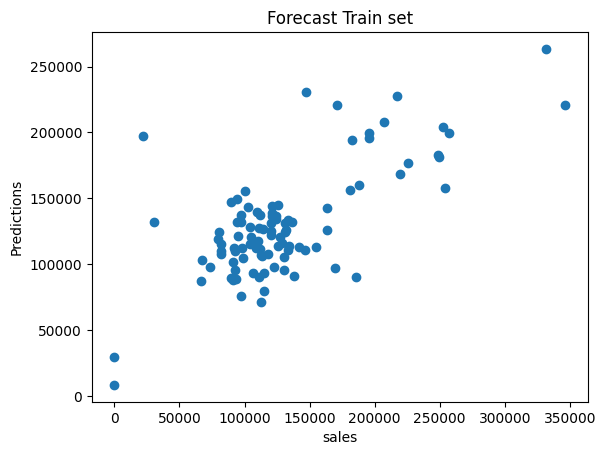

In [38]:
plt.scatter(y_train_t,preds)
plt.xlabel("sales")
plt.ylabel("Predictions")
plt.title("Forecast Train set")

In [39]:
mean_squared_error(preds,y_train_t,squared=False)

41256.12038517006

In [40]:
preds

array([199908.51264142, 194372.68014816, 197031.92122959,   8742.94880377,
        71348.24433247, 127439.18901881, 115739.91945369,  90676.55168699,
       121333.53830578,  87332.01826368,  80139.82115758, 110689.93683113,
       120489.87353694, 112670.77524385,  96183.06878971, 110727.52054733,
       118140.72321654,  93584.43433653, 107087.63018972, 108248.61219604,
       113505.9522303 , 128351.75507122,  90927.77518199, 122110.68048052,
       105471.8371787 , 119247.21488934,  90686.18063792, 155446.78561443,
        87993.44107447, 124454.17883019, 143228.45174586, 116349.64886571,
       131190.0757969 , 132062.61465756, 137765.84644785, 120500.15007263,
       125558.20597066, 134513.19743158, 149842.97818657, 131973.41460392,
       144777.22487709, 156343.46546488, 199355.96189466, 227408.62494354,
       183281.24809728, 195581.47701917, 142603.29953726, 168359.44263748,
       203841.22791631, 207770.33530742, 176583.98365126, 220999.71786098,
       263323.81194214, 2

In [41]:
y_train_t

week
2009-12-13    195810.040
2009-12-20    182396.740
2009-12-27     22007.770
2010-01-03         0.000
2010-01-10    112318.850
                 ...    
2011-09-11    131164.240
2011-09-18    187934.500
2011-09-25    249563.051
2011-10-02    170904.201
2011-10-09    253713.540
Name: sales, Length: 96, dtype: float64

In [42]:
X_test_t = pipe.fit_transform(X_test)

In [44]:
X_test_t.shape

(13, 10)

In [45]:
preds_test = linear_model.predict(X_test_t)

In [46]:
y_test_t = y_test.loc[X_test_t.index]

In [47]:
y_test_t.shape

(13,)

Text(0.5, 1.0, 'Forecast Test set')

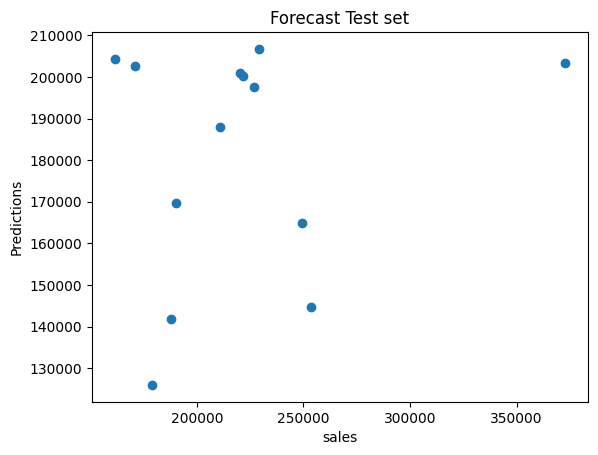

In [48]:
plt.scatter(y_test_t,preds_test)
plt.xlabel("sales")
plt.ylabel("Predictions")
plt.title("Forecast Test set")

In [49]:
mean_squared_error(preds_test,y_test_t,squared=False)

67193.97229140264